In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
# numpy.linalg is also an option for even fewer dependencies

Computing spectral radius...
done.
[[ 7.74175062e-02]
 [ 2.69453938e-01]
 [-4.61704136e-01]
 [-2.69723570e-01]
 [ 1.92073973e-01]
 [-2.61115888e-01]
 [ 2.00107203e-01]
 [-4.31270993e-01]
 [-1.82404858e-01]
 [-1.60977286e-01]
 [-5.03606308e-02]
 [-2.61654266e-01]
 [ 8.42497435e-02]
 [-2.86181502e-01]
 [-1.12124454e-01]
 [-4.09544020e-02]
 [-2.28669376e-01]
 [ 5.40351238e-01]
 [-3.60137449e-01]
 [ 1.55825405e-01]
 [-3.63092505e-01]
 [-2.74418731e-01]
 [-1.66033790e-01]
 [-1.77980498e-01]
 [-9.56486987e-02]
 [ 5.32513069e-01]
 [ 5.49584277e-01]
 [ 2.80761186e-01]
 [-4.99446210e-01]
 [-4.88018006e-01]
 [-2.11014456e-01]
 [ 2.58076801e-01]
 [-1.97461178e-01]
 [-2.19275228e-01]
 [-2.02720036e-01]
 [ 1.35628155e-01]
 [-3.38449978e-01]
 [ 3.00401115e-01]
 [ 7.93846657e-02]
 [-3.04341923e-01]
 [ 3.95337714e-01]
 [-3.50341508e-01]
 [-2.61605689e-01]
 [ 2.83624673e-01]
 [ 3.57671844e-01]
 [-2.76828130e-01]
 [ 2.80336924e-01]
 [ 2.61941694e-01]
 [-9.72735616e-03]
 [-5.72994436e-01]
 [-3.85859534e-

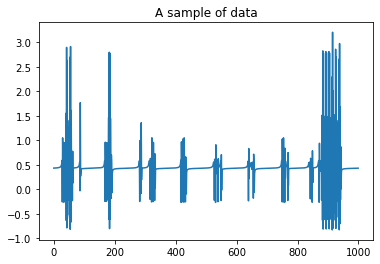

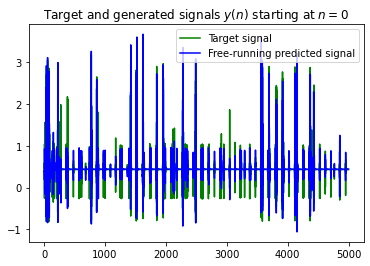

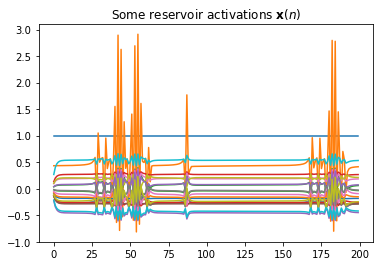

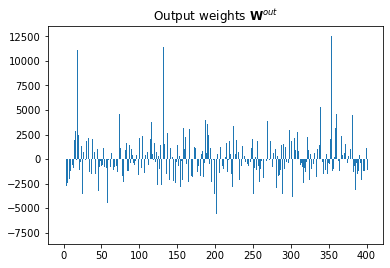

In [2]:


# load the data
trainLen = 45000
testLen = 4999
initLen = 0
data = np.loadtxt("./lienard_intermittency.dat")[:, 1]

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 400
a = 0.5 # leaking rate
np.random.seed(42)
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5 
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 0.001 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*np.tanh(np.dot(Win, np.vstack((1,u))) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
reservoir_end = x 
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    #u = y
    ## this would be a predictive mode:
    u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()

In [3]:
print(reservoir_end)

[[ 7.74175062e-02]
 [ 2.69453938e-01]
 [-4.61704136e-01]
 [-2.69723570e-01]
 [ 1.92073973e-01]
 [-2.61115888e-01]
 [ 2.00107203e-01]
 [-4.31270993e-01]
 [-1.82404858e-01]
 [-1.60977286e-01]
 [-5.03606308e-02]
 [-2.61654266e-01]
 [ 8.42497435e-02]
 [-2.86181502e-01]
 [-1.12124454e-01]
 [-4.09544020e-02]
 [-2.28669376e-01]
 [ 5.40351238e-01]
 [-3.60137449e-01]
 [ 1.55825405e-01]
 [-3.63092505e-01]
 [-2.74418731e-01]
 [-1.66033790e-01]
 [-1.77980498e-01]
 [-9.56486987e-02]
 [ 5.32513069e-01]
 [ 5.49584277e-01]
 [ 2.80761186e-01]
 [-4.99446210e-01]
 [-4.88018006e-01]
 [-2.11014456e-01]
 [ 2.58076801e-01]
 [-1.97461178e-01]
 [-2.19275228e-01]
 [-2.02720036e-01]
 [ 1.35628155e-01]
 [-3.38449978e-01]
 [ 3.00401115e-01]
 [ 7.93846657e-02]
 [-3.04341923e-01]
 [ 3.95337714e-01]
 [-3.50341508e-01]
 [-2.61605689e-01]
 [ 2.83624673e-01]
 [ 3.57671844e-01]
 [-2.76828130e-01]
 [ 2.80336924e-01]
 [ 2.61941694e-01]
 [-9.72735616e-03]
 [-5.72994436e-01]
 [-3.85859534e-01]
 [-1.79588604e-01]
 [ 2.8580791

In [5]:
from IPython.display import clear_output

In [30]:
#Y = np.zeros((outSize,testLen))
prediction = []
u = data[trainLen]
k = 3
x = reservoir_end
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    x_loop = x
    for j in range(k):
        y = np.dot( Wout, np.vstack((1,u,x_loop)) )
        
        # generative mode:
        u = y
        x_loop = (1-a)*x_loop + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x_loop ) )    
    prediction.append(y[0][0])
    ## this would be a predictive mode:
    u = data[trainLen+t+1] 

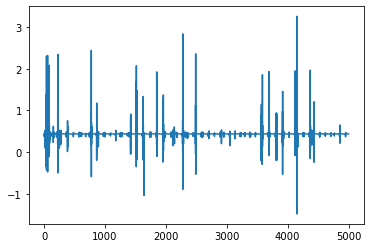

In [31]:
plt.plot(prediction)

In [39]:
rmse = []
for k in range(1, 21):
    prediction = []
    u = data[trainLen]
    #k = 3
    x = reservoir_end
    for t in range(testLen):
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
        x_loop = x
        for j in range(k):
            y = np.dot( Wout, np.vstack((1,u,x_loop)) )

            # generative mode:
            u = y
            x_loop = (1-a)*x_loop + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x_loop ) )    
        prediction.append(y[0][0])
        ## this would be a predictive mode:
        u = data[trainLen+t+1] 
    r = (((np.array(prediction[:-k]) - data[45000+k:-1])**2).mean())**0.5
    rmse.append(r)

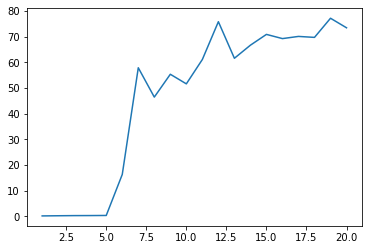

In [46]:
plt.plot(list(range(1, 21)),rmse)

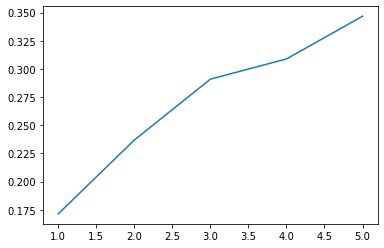

In [45]:
plt.plot(list(range(1, 6)),rmse[:5])

In [32]:
len(prediction)

4999

In [13]:
rmse = []

In [35]:
r = (((np.array(prediction[:-2]) - data[45003:])**2).mean())**0.5
r

0.2908550027358024

In [36]:
rmse.append(r)

In [9]:
Y.shape

(1, 4999)

In [11]:
np.save('RC_lienar', Y)

In [10]:
(((np.array(Y) - data[45001:])**2).mean())**0.5

0.17134487842168625

In [5]:
X

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.42399904,  0.42430433,  0.42459072, ...,  0.44758077,
         0.45033332,  0.4538997 ],
       [ 0.8923459 ,  0.89254202,  0.8927749 , ...,  0.89638721,
         0.89665346,  0.89697697],
       ...,
       [ 0.73307468,  0.73368373,  0.73441142, ...,  0.72954385,
         0.72973722,  0.72995825],
       [-0.00456642, -0.01124944, -0.01794039, ..., -0.08379933,
        -0.08506902, -0.08664056],
       [-0.60433966, -0.60708818, -0.60992258, ..., -0.64688467,
        -0.64700034, -0.64715967]])

In [6]:
Yt

array([[0.42430433, 0.42459072, 0.42485679, ..., 0.45033332, 0.4538997 ,
        0.45869201]])